In [ ]:
import pandas as pd
import pickle

# Define the cube number
cube = 5

# Load final_data_list
with open(f'./Data/final_data_list_cube_{cube}.pkl', 'rb') as f:
    final_data_list = pickle.load(f)

# Define the path to the Excel file
excel_path = './Parameters.xlsx'  

# Define the page to be used
sheet_name = f"Cube {cube}"

# Try to read the Excel file into a DataFrame
try:
    df_conditions = pd.read_excel(excel_path, sheet_name=sheet_name)
    print("Successfully read the Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")

# Display the DataFrame and some dimensions of the arrays
df_conditions.head(), len(final_data_list), final_data_list[0].shape if final_data_list else None


In [ ]:
df_conditions

In [ ]:
# Import numpy for calculations
import numpy as np

# Initializing a list to store the final average values for each condition
averages = []

# Looping over each condition in final_data_list
for data in final_data_list:
    # Removing the first two lines (reducing from 10 to 8 lines)
    reduced_data = data[:, 2:, :]

    # Removing the last 10% of each line
    cut_length = int(reduced_data.shape[2] * 0.9)
    reduced_data = reduced_data[:, :, :cut_length]

    # Calculating the median line 
    median_line = np.median(reduced_data, axis=1)

    # Calculating the average (reducing from (2, 1, N) to (2, 1, 1))
    average_values = np.mean(median_line, axis=1).reshape(2, 1)

    # Appending the average values to the list
    averages.append(average_values)

# Converting the list of averages to a numpy array for easier handling
averages_array = np.array(averages)

# Creating new columns in the DataFrame for the average values of each channel
df_conditions['Average Optical Emission'] = averages_array[:, 0, 0]
df_conditions['Average Optical Reflection'] = averages_array[:, 1, 0]

# Displaying the updated DataFrame
df_conditions.head()


In [ ]:
max_OE = np.max(df_conditions['Average Optical Emission'].values)
max_OR = np.max(df_conditions['Average Optical Reflection'].values)

min_OE = np.min(df_conditions['Average Optical Emission'].values)
min_OR = np.min(df_conditions['Average Optical Reflection'].values)


In [ ]:
df_conditions['Norm Optical Emission'] = (df_conditions['Average Optical Emission'].values - min_OE)/(max_OE - min_OE)*2-1
df_conditions['Norm Optical Reflection'] = (df_conditions['Average Optical Reflection'].values - min_OR)/(max_OR - min_OR)*2-1

In [ ]:
df_conditions

In [ ]:
# Creating a database
X = np.stack([df_conditions['Norm Optical Emission'].values, df_conditions['Norm Optical Reflection'].values]).reshape(X.shape[1], X.shape[0])
X.shape

In [ ]:
X[:, 0].shape, X[:, 1].shape

In [ ]:
OE_OR = X[:, 0] * X[:, 1]
OE_OR.shape

In [ ]:
OE_2 = X[:, 0] ** 2
OE_2.shape

In [ ]:
OR_2 = X[:, 1] ** 2
OR_2.shape

In [ ]:
# Preparing the data for polynomial regression
# Adding squared terms and interaction term
X_poly = np.hstack((
    X[:, 0].reshape(-1,1),
    X[:, 1].reshape(-1,1),
    OE_OR.reshape(-1,1),  # OE*OR interaction
    OE_2.reshape(-1,1),  # OE^2
    OR_2.reshape(-1,1)   # OR^2
))

X_poly.shape


In [ ]:
# Define the target 
y = df_conditions['Surface Area']

y.shape

In [ ]:
from sklearn import linear_model


# Training the linear regression model on the polynomial features
model = linear_model.LinearRegression()
model.fit(X_poly, y)

# Coefficients for the linear, interaction, and squared terms
coefficients = [model.intercept_] + list(model.coef_)

coefficients

In [ ]:
# Mean error in train
np.mean((model.predict(X_poly) - y)**2)

In [ ]:
# R2
model.score(X_poly, y)

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(model.predict(X_poly))
plt.plot(y) 

In [ ]:
# Mapping each condition to its corresponding array in final_data_list
condition_to_array_map = {condition: array for condition, array in zip(df_conditions['#'], final_data_list)}
condition_to_array_map

In [ ]:
condition_to_array_map[2].shape

In [ ]:
channels = ['Optical Emission', 'Optical Reflection']

In [ ]:
# Identifying conditions with the same power but different speeds
grouped_by_power = df_conditions.groupby('Powers (W)')

# Dictionary to store conditions with the same power but different speeds
conditions_same_power_diff_speed = {}

for power, group in grouped_by_power:
    unique_speeds = group['Speed (mm/s)'].nunique()
    if unique_speeds > 1:
        conditions_same_power_diff_speed[power] = group['#'].tolist()

conditions_same_power_diff_speed


In [ ]:
# Sorting the conditions by speed for each power level
sorted_conditions_by_speed = {power: sorted(conditions, key=lambda x: df_conditions[df_conditions['#'] == x]['Speed (mm/s)'].iloc[0]) for power, conditions in conditions_same_power_diff_speed.items()}

sorted_conditions_by_speed

In [ ]:
import numpy as np 
# Initialize dictionaries to store mean and standard deviation results
mean_std_results = {}

# Loop through each power level and its corresponding sorted conditions
for power in sorted_conditions_by_speed.keys():
    mean_std_results[power] = {'Optical Emission': [], 'Optical Reflection': []}
    
    # Loop through each channel
    for channel_idx, channel in enumerate(['Optical Emission', 'Optical Reflection']):
        conditions = sorted_conditions_by_speed[power]
        
        # Loop through each condition to collect data
        for condition in conditions:
            array_data = condition_to_array_map[condition]
            
            # Trim data to remove last 10% from each line
            array_data_trimmed = array_data[channel_idx, :, :int(array_data.shape[2]*.9)]
            
            # Compute the mean line
            array_mean_line = np.mean(array_data_trimmed, axis=0)
            
            # Find the corresponding speed
            speed = df_conditions[df_conditions['#'] == condition]['Speed (mm/s)'].iloc[0]
            
            # Calculate mean and standard deviation
            mean_value = np.mean(array_mean_line)
            std_value = np.std(array_mean_line)
            
            mean_std_results[power][channel].append((speed, mean_value, std_value))

mean_std_results


In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure for visualization
fig, axes = plt.subplots(len(mean_std_results), 2, figsize=(20, 4*len(mean_std_results)))

# Loop through each power level and its corresponding mean and std results
for idx, (power, mean_std_channel) in enumerate(mean_std_results.items()):
    for channel_idx, channel in enumerate(['Optical Emission', 'Optical Reflection']):
        mean_std_data = mean_std_channel[channel]
        speeds = [speed for speed, _, _ in mean_std_data]
        means = [mean for _, mean, _ in mean_std_data]
        stds = [std for _, _, std in mean_std_data]
        
        # Generate the error bar plot
        axes[idx, channel_idx].errorbar(speeds, means, yerr=stds, fmt='o-', label='Mean ± Std')
        axes[idx, channel_idx].set_title(f'Mean and Std for {channel} at Power {int(power)} W')
        axes[idx, channel_idx].set_xlabel('Speed (mm/s)')
        axes[idx, channel_idx].set_ylabel('Value')
        axes[idx, channel_idx].set_xlim([250, 1850])
        axes[idx, channel_idx].legend()
        axes[idx, channel_idx].grid()
        

plt.tight_layout()
plt.show()


In [ ]:
def get_surface_area(power, speed, df):
    """
    Function to get the surface area for a given power and speed from the DataFrame.

    :param power: Power level (in Watts)
    :param speed: Speed (in mm/s)
    :param df: DataFrame containing the data
    :return: Surface area corresponding to the given power and speed
    """
    # Filter the DataFrame for the given power and speed
    filtered_df = df[(df['Powers (W)'] == power) & (df['Speed (mm/s)'] == speed)]

    # Check if there is an entry for the given power and speed
    if not filtered_df.empty:
        return filtered_df['Surface Area'].iloc[0]
    else:
        return "No data available for the specified power and speed."

# Testing the function with a power and speed from the DataFrame
test_power = 120
test_speed = 800
surface_area_result = get_surface_area(test_power, test_speed, df_conditions)

surface_area_result



In [ ]:
import matplotlib.pyplot as plt

# Initialize the figure for visualization
fig, axes = plt.subplots(len(mean_std_results), 2, figsize=(20, 4*len(mean_std_results)))

# Loop through each power level and its corresponding mean and std results
for idx, (power, mean_std_channel) in enumerate(mean_std_results.items()):
    # Filter the DataFrame for the current power level
    df_filtered = df_conditions[df_conditions['Powers (W)'] == power]

    for channel_idx, channel in enumerate(['Optical Emission', 'Optical Reflection']):
        mean_std_data = mean_std_channel[channel]
        speeds = [speed for speed, _, _ in mean_std_data]
        means = [mean for _, mean, _ in mean_std_data]
        stds = [std for _, _, std in mean_std_data]
        
        # Sort the DataFrame by speed and then retrieve surface area
        df_sorted = df_filtered.sort_values('Speed (mm/s)')
        surface_areas = df_sorted[df_sorted['Speed (mm/s)'].isin(speeds)]['Surface Area'].values


        # Generate the error bar plot for mean and std
        axes[idx, channel_idx].errorbar(speeds, means, yerr=stds, fmt='o-', label='Mean ± Std')
        
        # Add a secondary y-axis for surface area
        ax2 = axes[idx, channel_idx].twinx()
        ax2.plot(speeds, surface_areas, 'r^-', label='Surface Area')
        ax2.set_ylabel('Surface Area', color='r')

        # Set titles and labels
        axes[idx, channel_idx].set_title(f'Mean and Std for {channel} at Power {int(power)} W')
        axes[idx, channel_idx].set_xlabel('Speed (mm/s)')
        axes[idx, channel_idx].set_ylabel('Value')
        axes[idx, channel_idx].set_xlim([250, 1850])

        # Add legends
        axes[idx, channel_idx].legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Add grid
        axes[idx, channel_idx].grid()
        
plt.tight_layout()
plt.show()


In [ ]:
speeds

In [ ]:
df_filtered[df_filtered['Speed (mm/s)'].isin(speeds)]

In [ ]:
df_conditions 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

# Extracting the necessary data for mean optical emission and reflection from the DataFrame
df_conditions['Mean Optical Emission'] = df_conditions.apply(
    lambda row: np.mean(np.mean(condition_to_array_map[row['#']][0], axis=1)), axis=1)
df_conditions['Mean Optical Reflection'] = df_conditions.apply(
    lambda row: np.mean(np.mean(condition_to_array_map[row['#']][1], axis=1)), axis=1)



In [ ]:
df_conditions

In [ ]:
# Identifying conditions with the same power but different speeds
grouped_by_power = df_conditions.groupby('Powers (W)')


In [ ]:
# Re-plotting the true surface area using the corrected mean values
fig, axes = plt.subplots(len(grouped_by_power), 1, figsize=(10, 5*len(grouped_by_power)))

# Ensure axes is an iterable (for a single plot case)
if len(grouped_by_power) == 1:  
    axes = [axes]

# Loop through each power level
for idx, (power, group) in enumerate(grouped_by_power):
    # Plotting the actual surface area
    axes[idx].plot(group['Speed (mm/s)'], group['Surface Area'], 'o-', label='Actual Surface Area')
    
    # Set titles and labels
    axes[idx].set_title(f'Surface Area for Power {power} W')
    axes[idx].set_xlabel('Speed (mm/s)')
    axes[idx].set_ylabel('Surface Area')
    axes[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Re-plotting with actual mean Optical Emission and Reflection values, using two different y-scales
fig, axes = plt.subplots(len(grouped_by_power), 1, figsize=(10, 5 * len(grouped_by_power)))

# Ensure axes is an iterable (for a single plot case)
if len(grouped_by_power) == 1:
    axes = [axes]

# Loop through each power level
for idx, (power, group) in enumerate(grouped_by_power):
    # Sort the group by 'Speed (mm/s)'
    group_sorted = group.sort_values(by='Speed (mm/s)')
    
    # Create a second y-axis for the optical reflection
    ax2 = axes[idx].twinx()

    # Plotting the actual mean Optical Emission with a line
    axes[idx].plot(group_sorted['Speed (mm/s)'], group_sorted['Mean Optical Emission'], color='blue', label='Mean Optical Emission')

    # Plotting the actual mean Optical Reflection on the second y-axis with a line
    ax2.plot(group_sorted['Speed (mm/s)'], group_sorted['Mean Optical Reflection'], color='red', label='Mean Optical Reflection')

    # Set titles and labels
    axes[idx].set_title(f'Mean Optical Emission and Reflection for Power {power} W')
    axes[idx].set_xlabel('Speed (mm/s)')
    axes[idx].set_ylabel('Mean Optical Emission', color='blue')
    ax2.set_ylabel('Mean Optical Reflection', color='red')

    # Add legends
    axes[idx].legend(loc='upper left')
    ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the pickle file containing the final data list
with open('./Data/final_data_list_cube_5.pkl', 'rb') as f:
    final_data_list = pickle.load(f)

# Load the Excel file containing the parameters
excel_path = './Parameters.xlsx'
sheet_name = "Cube 5"

# Read the Excel file into a DataFrame
df_conditions = pd.read_excel(excel_path, sheet_name=sheet_name)

df_conditions

,Speed (mm/s),Powers (W),Powers perc (%),#,T_0 (°C),Norm Speed,Norm Power,Norm T_0,Surface Area
0,966.666667,106.666667,21.333333,1,27,-0.377778,1.333333,-1,0.014332
1,1633.333333,106.666667,21.333333,2,27,0.511111,1.333333,-1,0.008014
2,1466.666667,120.000000,24.000000,3,27,0.288889,2.000000,-1,0.011958
3,633.333333,120.000000,24.000000,4,27,-0.822222,2.000000,-1,0.022060
4,1800.000000,120.000000,24.000000,5,27,0.733333,2.000000,-1,0.007956
5,1133.333333,80.000000,16.000000,6,27,-0.155556,0.000000,-1,0.006504
6,800.000000,120.000000,24.000000,7,27,-0.600000,2.000000,-1,0.020028
7,1300.000000,93.333333,18.666667,8,27,0.066667,0.666667,-1,0.008435
8,1300.000000,80.000000,16.000000,9,27,0.066667,0.000000,-1,0.005786
9,633.333333,93.333333,18.666667,10,27,-0.822222,0.666667,-1,0.013068


In [5]:
import numpy as np
# Initializing a list to store the final average values for each condition
averages = []

# Looping over each condition in final_data_list
for data in final_data_list:
    # Removing the first two lines (reducing from 10 to 8 lines)
    reduced_data = data[:, 2:, :]

    # Removing the last 10% of each line
    cut_length = int(reduced_data.shape[2] * 0.9)
    reduced_data = reduced_data[:, :, :cut_length]

    # Calculating the median line (reducing from (2, 8, N) to (2, 1, N))
    median_line = np.median(reduced_data, axis=1)

    # Calculating the average (reducing from (2, 1, N) to (2, 1, 1))
    average_values = np.mean(median_line, axis=1).reshape(2, 1)

    # Appending the average values to the list
    averages.append(average_values)

# Converting the list of averages to a numpy array for easier handling
averages_array = np.array(averages)

# Creating new columns in the DataFrame for the average values of each channel
df_conditions['Average Optical Emission'] = averages_array[:, 0, 0]
df_conditions['Average Optical Reflection'] = averages_array[:, 1, 0]

# Preparing the data for the polynomial regression model
X = df_conditions[['Average Optical Emission', 'Average Optical Reflection']]
y = df_conditions['Surface Area']

X.shape



(32, 2)

In [22]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Creating polynomial features
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Building the regression model
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_poly_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(8.16931713448664e-06, 0.6731639660853221)

In [25]:
X_poly_train.shape

(19, 6)

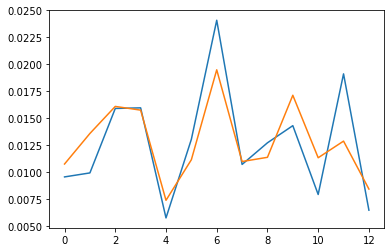

In [23]:
import matplotlib.pyplot as plt
plt.plot(y_test.values)
plt.plot(y_pred)

In [16]:
y_test

29    0.009585
15    0.009954
24    0.015925
17    0.015982
8     0.005786
9     0.013068
30    0.024097
Name: Surface Area, dtype: float64

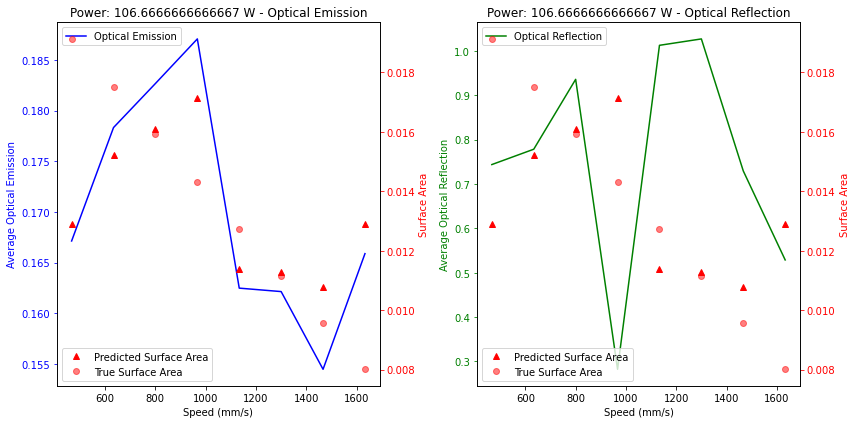

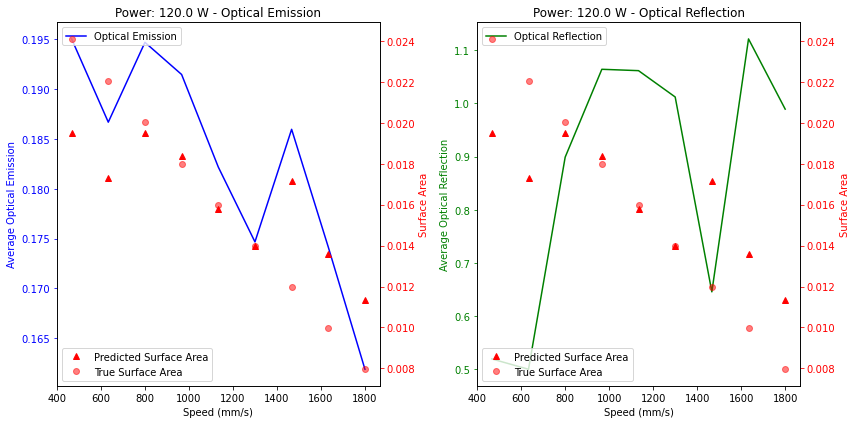

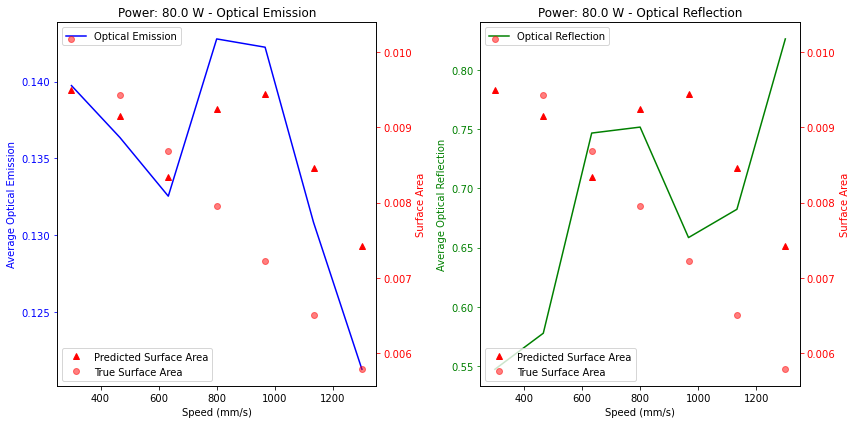

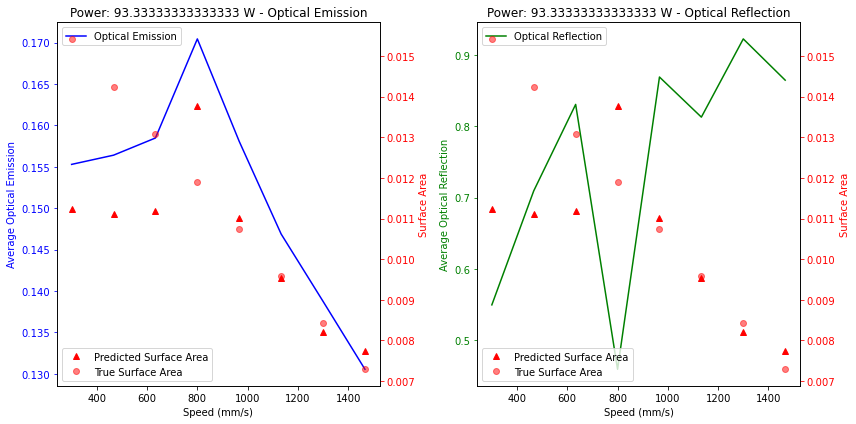

In [33]:
import matplotlib.pyplot as plt

# Creating polynomial features for prediction (including interaction term)
poly_features = PolynomialFeatures(degree=2)
X_full_poly = poly_features.fit_transform(X)

# Predicting surface area for all data points
df_conditions['Predicted Surface Area'] = model.predict(X_full_poly)

# Unique power levels
unique_powers = df_conditions['Powers (W)'].unique()

for power in unique_powers:
    # Filtering data by power and sorting by speed
    df_power = df_conditions[df_conditions['Powers (W)'] == power].sort_values(by='Speed (mm/s)')

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting Average Optical Emission vs. Speed
    ax1.plot(df_power['Speed (mm/s)'], df_power['Average Optical Emission'], 'b-', label='Optical Emission')
    ax1.set_xlabel('Speed (mm/s)')
    ax1.set_ylabel('Average Optical Emission', color='b')
    ax1.tick_params('y', colors='b')

    # Twin axis for predicted and true surface area
    ax1b = ax1.twinx()
    ax1b.plot(df_power['Speed (mm/s)'], df_power['Predicted Surface Area'], 'r^', label='Predicted Surface Area')
    ax1b.plot(df_power['Speed (mm/s)'], df_power['Surface Area'], 'ro', label='True Surface Area', alpha=0.5)
    ax1b.set_ylabel('Surface Area', color='r')
    ax1b.tick_params('y', colors='r')
    ax1.set_title(f'Power: {power} W - Optical Emission')

    # Plotting Average Optical Reflection vs. Speed
    ax2.plot(df_power['Speed (mm/s)'], df_power['Average Optical Reflection'], 'g-', label='Optical Reflection')
    ax2.set_xlabel('Speed (mm/s)')
    ax2.set_ylabel('Average Optical Reflection', color='g')
    ax2.tick_params('y', colors='g')

    # Twin axis for predicted and true surface area
    ax2b = ax2.twinx()
    ax2b.plot(df_power['Speed (mm/s)'], df_power['Predicted Surface Area'], 'r^', label='Predicted Surface Area')
    ax2b.plot(df_power['Speed (mm/s)'], df_power['Surface Area'], 'ro', label='True Surface Area', alpha=0.5)
    ax2b.set_ylabel('Surface Area', color='r')
    ax2b.tick_params('y', colors='r')
    ax2.set_title(f'Power: {power} W - Optical Reflection')

    # Adding legends
    ax1.legend(loc='upper left')
    ax1b.legend(loc='lower left')
    ax2.legend(loc='upper left')
    ax2b.legend(loc='lower left')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [29]:
df_power['Speed (mm/s)']

7     1300.000000
9      633.333333
13    1466.666667
14     466.666667
22    1133.333333
25     966.666667
27     300.000000
31     800.000000
Name: Speed (mm/s), dtype: float64

In [30]:
df_power['Average Optical Emission']

7     0.138755
9     0.158486
13    0.130552
14    0.156411
22    0.146888
25    0.158072
27    0.155300
31    0.170454
Name: Average Optical Emission, dtype: float64

ValueError: s must be a scalar, or float array-like with the same size as x and y

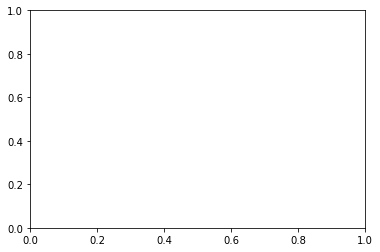

In [28]:
plt.scatter(df_power['Speed (mm/s)'], df_power['Average Optical Emission'], 'b-', label='Optical Emission')


In [ ]:
# Normalizing the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Preparing the data for polynomial regression
# Adding squared terms and interaction term
X_poly = np.hstack((
    X_normalized, 
    X_normalized[:, 0].reshape(-1, 1) * X_normalized[:, 1].reshape(-1, 1),  # OE*OR interaction
    X_normalized[:, 0].reshape(-1, 1)**2,  # OE^2
    X_normalized[:, 1].reshape(-1, 1)**2   # OR^2
))

# Training the linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Coefficients for the linear, interaction, and squared terms
coefficients = [model.intercept_] + list(model.coef_)

coefficients


In [ ]:
# Loop through each power level
for idx, (power, group) in enumerate(grouped_by_power):
    break

In [ ]:
group

In [ ]:
plt.scatter(list(group['Speed (mm/s)'].values), list(group['Surface Area'].values))

In [ ]:
group['Surface Area'].values

In [ ]:
list(group['Speed (mm/s)'].values)

In [ ]:
plt.plot(speeds, surface_areas, 'r^-', label='Surface Area')

In [ ]:
speeds

In [ ]:
surface_areas

In [ ]:
# Re-plotting the optical emission and reflection using corrected mean values
fig, axes = plt.subplots(len(grouped_by_power), 1, figsize=(10, 5 * len(grouped_by_power)))

# Ensure axes is an iterable (for a single plot case)
if len(grouped_by_power) == 1:
    axes = [axes]

# Loop through each power level
for idx, (power, group) in enumerate(grouped_by_power):
    ax2 = axes[idx].twinx()  # Create a second y-axis for the optical reflection

    # Plotting the mean optical emission and reflection on separate y-axes
    emission_line, = axes[idx].scatter(group['Speed (mm/s)'], group['Mean Optical Emission'], 'o-', label='Mean Optical Emission', color='blue')
    reflection_line, = ax2.scatter(group['Speed (mm/s)'], group['Mean Optical Reflection'], 'x-', label='Mean Optical Reflection', color='red')
    
    # Set titles and labels
    axes[idx].set_title(f'Mean Optical Emission and Reflection for Power {power} W')
    axes[idx].set_xlabel('Speed (mm/s)')
    axes[idx].set_ylabel('Mean Optical Emission', color='blue')
    ax2.set_ylabel('Mean Optical Reflection', color='red')
    
    # Adding legends
    lines = [emission_line, reflection_line]
    axes[idx].legend(lines, [l.get_label() for l in lines])

# Adjust layout
plt.tight_layout()
plt.show()
